In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import networkx as nx
import numpy as np
import os

# --- KONFIGURASI FOLDER ---
DATA_DIR = 'data'  # Pastikan folder ini benar

def load_csv(filename):
    path = os.path.join(DATA_DIR, filename)
    try:
        df = pd.read_csv(path)
        print(f"✅ Berhasil load: {filename} ({len(df)} baris)")
        return df
    except FileNotFoundError:
        print(f"❌ ERROR: File {filename} tidak ditemukan di folder '{DATA_DIR}'")
        return None

print("--- 1. LOAD DATA SPASIAL (PETA) ---")
zone_df = load_csv('zone_config.csv')
nodes_df = load_csv('path_nodes.csv')
edges_df = load_csv('path_edges.csv')
gen_facilities_df = load_csv('general_facilities.csv') # Untuk visual (Pohon/Tong Sampah)

print("\n--- 2. LOAD DATA LOGIKA TAMAN ---")
park_facilities_df = load_csv('park_facilities.csv')   # Untuk kapasitas & fungsi (Bangku/Alat Gym)
activity_df = load_csv('activity_usage_profile.csv')   # Aturan aktivitas (Durasi/Energi)

print("\n--- 3. LOAD DATA DINAMIS (WAKTU & CUACA) ---")
arrival_df = load_csv('arrival_profile_weekend_counts.csv')
env_df = load_csv('env_schedule_weekend.csv')

print("\n--- 4. LOAD DATA AGEN (PENGUNJUNG) ---")
survey_df = load_csv('survey_preferences_1000.csv')

print("\n--- STATUS ---")
if all(v is not None for v in [zone_df, nodes_df, edges_df, gen_facilities_df, park_facilities_df, activity_df, arrival_df, env_df, survey_df]):
    print("🎉 SEMUA DATA SIAP! Silakan lanjut ke visualisasi.")
else:
    print("⚠️ Ada data yang hilang. Cek folder data kamu.")

--- 1. LOAD DATA SPASIAL (PETA) ---
✅ Berhasil load: zone_config.csv (31 baris)
✅ Berhasil load: path_nodes.csv (123 baris)
✅ Berhasil load: path_edges.csv (125 baris)
✅ Berhasil load: general_facilities.csv (79 baris)

--- 2. LOAD DATA LOGIKA TAMAN ---
✅ Berhasil load: park_facilities.csv (24 baris)
✅ Berhasil load: activity_usage_profile.csv (11 baris)

--- 3. LOAD DATA DINAMIS (WAKTU & CUACA) ---
✅ Berhasil load: arrival_profile_weekend_counts.csv (90 baris)
✅ Berhasil load: env_schedule_weekend.csv (90 baris)

--- 4. LOAD DATA AGEN (PENGUNJUNG) ---
✅ Berhasil load: survey_preferences_1000.csv (1000 baris)

--- STATUS ---
🎉 SEMUA DATA SIAP! Silakan lanjut ke visualisasi.


In [2]:
# --- BANGUN GRAPH JALAN ---
G = nx.Graph()

if nodes_df is not None and edges_df is not None:
    # Nodes
    for _, row in nodes_df.iterrows():
        G.add_node(row['node_id'], pos=(row['x_px'], row['y_px']))

    # Edges
    for _, row in edges_df.iterrows():
        G.add_edge(row['from_node'], row['to_node'])

    print(f"✅ Graph Jaringan Jalan Terbangun: {G.number_of_nodes()} titik, {G.number_of_edges()} jalur.")
else:
    print("❌ Gagal membangun graph karena data node/edge hilang.")

✅ Graph Jaringan Jalan Terbangun: 123 titik, 125 jalur.


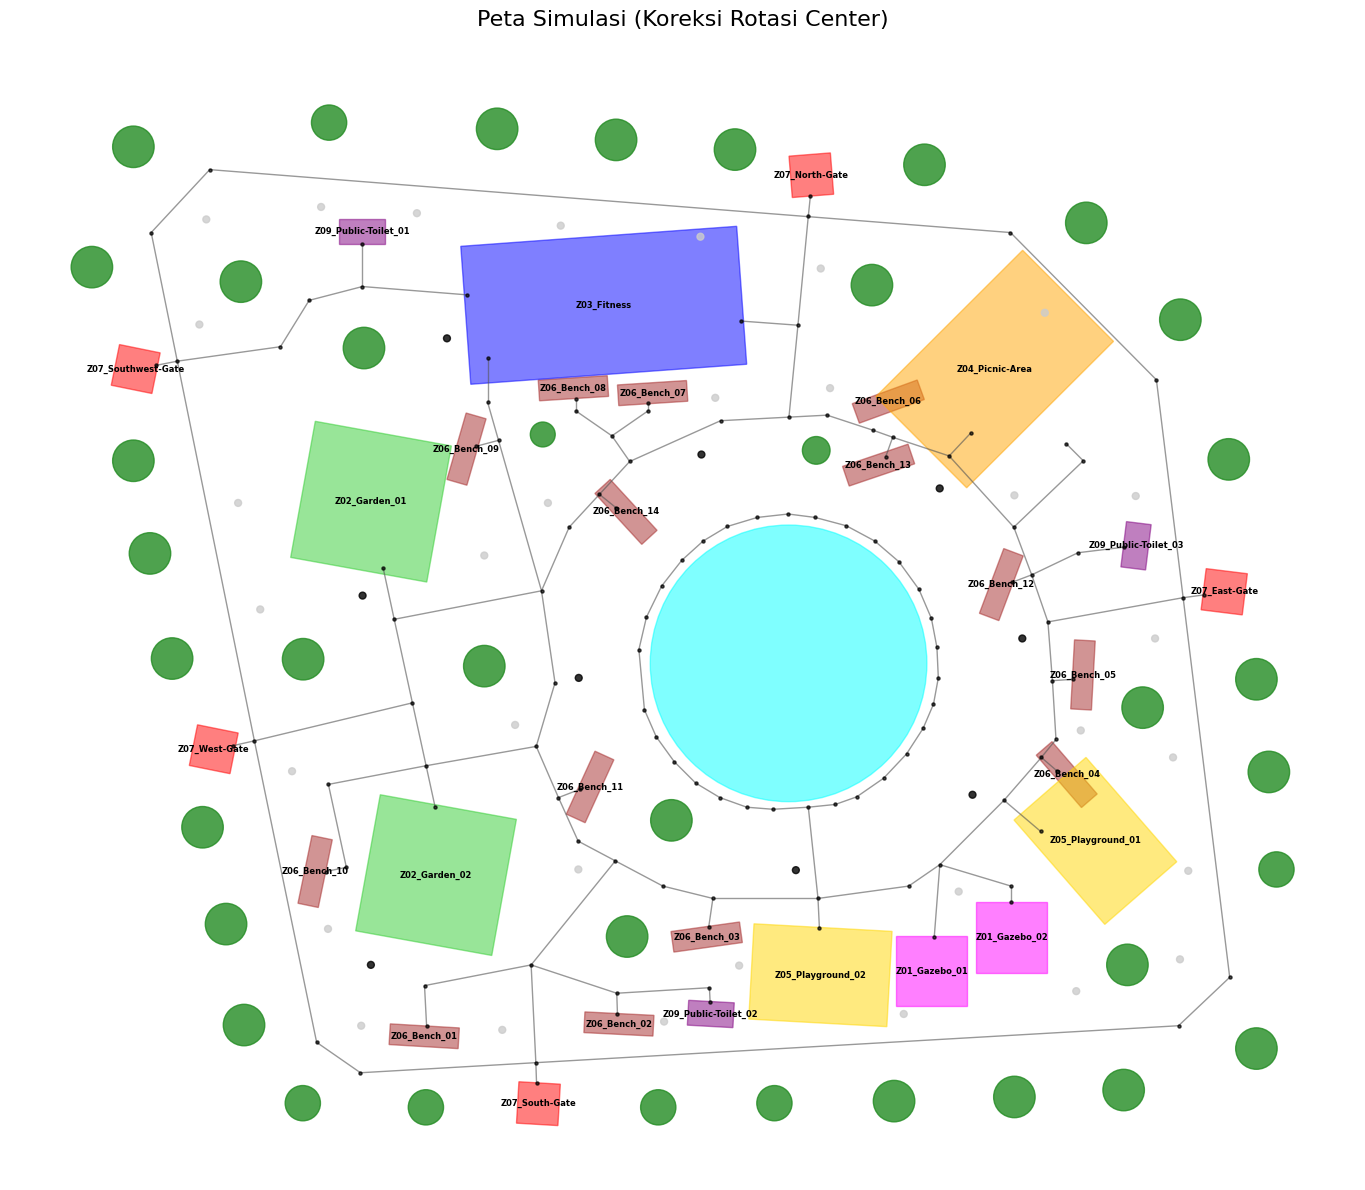

In [3]:
# --- 3. VISUALISASI TEMA TERANG (DENGAN KOREKSI ROTASI) ---
import matplotlib.transforms as transforms

def draw_park_corrected(zones, visual_facilities, graph):
    if zones is None or graph is None:
        print("Data visualisasi belum lengkap.")
        return

    # Setup Canvas Putih
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Palet Warna
    COLORS = {
        "gazebo": "magenta", "garden": "limegreen", "fitness_zone": "blue",
        "picnic_area": "orange", "playground": "#ffd700", "fountain_zone": "cyan",
        "gate": "red", "public_toilet": "purple", "food_court": "pink",
        "bench_zone": "brown", "shelter": "teal", "indoor": "navy",
        "plaza": "#e0e0e0", "parking": "#d3d3d3", "running_track": "#a9a9a9",
        "tree": "#228b22", "trash_bin": "black"
    }

    def draw_shapes(df, is_facility=False):
        if df is None: return
        for _, row in df.iterrows():
            # Setup Properti
            if is_facility:
                obj_type = row['facility_type']
                w, h = row.get('size1_px', 10), row.get('size2_px', 10)
            else:
                obj_type = row.get('zone_type', 'unknown')
                w, h = row['width_px'], row['height_px']

            color = COLORS.get(obj_type, '#cccccc')
            alpha = 0.8 if is_facility else 0.5
            cx, cy = row['x_center_px'], row['y_center_px']
            rotation = row.get('rotation_deg', 0)

            if row['shape'] == 'rect':
                # --- LOGIKA KOREKSI ROTASI ---
                # 1. Buat kotak di titik (0,0) dulu biar gampang diputar
                # Titik sudut kiri-bawah relatif terhadap center (0,0)
                rect = Rectangle((-w/2, -h/2), w, h, 
                                 linewidth=1, edgecolor=color, facecolor=color, alpha=alpha)
                
                # 2. Buat transformasi: Geser ke Center -> Putar -> Geser ke Posisi Asli
                # Matplotlib butuh urutan transformasi yang spesifik
                t = transforms.Affine2D().rotate_deg(-rotation).translate(cx, cy) + ax.transData
                rect.set_transform(t)
                
                ax.add_patch(rect)
                
                # Label ID (Ikut diputar atau tetap tegak? Kita buat tetap tegak biar terbaca)
                if not is_facility and 'zone_id' in row:
                    ax.text(cx, cy, str(row['zone_id']), color='black', fontsize=6, 
                            ha='center', va='center', fontweight='bold')
                    
            elif row['shape'] == 'circle':
                circ = Circle((cx, cy), w / 2, linewidth=1, edgecolor=color, facecolor=color, alpha=alpha)
                ax.add_patch(circ)

    # Render
    draw_shapes(zones, is_facility=False)
    
    # Render Path (Graph) - PENTING: Cek apakah titik node ada DI DALAM kotak zona
    pos = nx.get_node_attributes(graph, 'pos')
    nx.draw_networkx_edges(graph, pos, ax=ax, edge_color='#555555', width=1.0, alpha=0.6)
    nx.draw_networkx_nodes(graph, pos, ax=ax, node_size=5, node_color='black', alpha=0.7)
    
    draw_shapes(visual_facilities, is_facility=True) 

    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')
    plt.title("Peta Simulasi (Koreksi Rotasi Center)", color='black', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Jalankan Koreksi
draw_park_corrected(zone_df, gen_facilities_df, G)